## Classificadores - características morfométricas de núcleo/citoplasma de células cervicais (Base CRIC)

In [21]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import feature_selection as fs

from itertools import cycle

from random import randint
from random import sample

import xgboost as xgb 

import csv
#sys.path.append(os.path.abspath("D:/baseCRIC/SegmentacaoCriC/shape_based_classifier"))
import functions  as fn

In [2]:
#IMG_W = 1376
#IMG_H = 1020
#Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
#Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 
PATH_masks = "D:/baseCRIC/SegmentacaoCriC/mascaras" 

### Classificador Normal vs Anormal(ASC-US, ASC-H, LSIL, HSIL, Carcinoma)

#####  Filtra dados por classe

In [4]:
df_nucleos, df_cyto,df_nucleos_full, df_cyto_full = fn.list_cells('./base/nucleus-segmentations.csv', './base/cytoplasm-segmentations.csv') 

In [5]:
count_cells, dfAll = fn.make_stats(df_nucleos, df_cyto, df_nucleos_full, df_cyto_full, fn.const)


In [6]:
#columns = fn.get_list_feature_labels()
#columns.append('bethesda')
columns = dfAll.columns
df = dfAll 
df.to_csv('dataCRIC.csv', sep = '|', index=False)
df.values.shape 

(3233, 123)

In [10]:
df2 = pd.read_csv('dataCRIC.csv', sep='|', index_col=False,  header=0)
max(df['kN']), min(df['kN']) 

(array([1.28801059]), array([-1.16620776]), '[1.28801059]', '[-0.03448496]')

In [11]:
# Separa dados por classe de maneira balanceada:
N_CLASSES = 2

data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 


--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


### Seleção de características:

In [12]:
N_FEATURES = 20   # Seleção das 20 features mais relevantes
 

In [79]:
## Normaliza dados
def normalize(min, max, value):
    return (value-min)/(max - min)

def normalize_prop(prop, df):
    min = np.min(df[prop].values)
    max = np.max(df[prop].values)
    return (normalize(min, max, df[prop].values))

# Filtra/normaliza dados
def normalize_dataset(df):
  dataset = df.copy()
   
  dataset.areaN = normalize_prop('areaN', df)
  dataset.eccenN = normalize_prop('eccenN', df) 
  dataset.extentN = normalize_prop('extentN', df)
  dataset.periN = normalize_prop('periN', df)
  dataset.maxAxN = normalize_prop('maxAxN', df)  
  dataset.minAxN = normalize_prop('minAxN', df)  
  dataset.compacN = normalize_prop('compacN', df)
  dataset.circuN = normalize_prop('circuN', df)
  dataset.convexN = normalize_prop('convexN', df)
  dataset.hAreaN = normalize_prop('hAreaN', df)
  dataset.solidN = normalize_prop('solidN', df) 
  dataset.equidiaN = normalize_prop('equidiaN', df) 
  dataset.elonN = normalize_prop('elonN', df)
  dataset.eN = normalize_prop('eN', df)  
     
  dataset.kN = normalize_prop('kN', df)  
  dataset.mrdN = normalize_prop('mrdN', df)  
  dataset.ardN = normalize_prop('ardN', df)  
  dataset.fdN = normalize_prop('fdN', df)       
  efds = ['efdN'+str(i) for i in range(1,38)]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df) 
    
  dataset.areaC = normalize_prop('areaC', df)
  dataset.eccenC = normalize_prop('eccenC', df) 
  dataset.extentC = normalize_prop('extentC', df)
  dataset.periC = normalize_prop('periC', df)
  dataset.maxAxC = normalize_prop('maxAxC', df)  
  dataset.minAxC = normalize_prop('minAxC', df)
  dataset.compacC = normalize_prop('compacC', df)
  dataset.circuC = normalize_prop('circuC', df)
  dataset.convexC = normalize_prop('convexC', df)
  dataset.hAreaC = normalize_prop('hAreaC', df)
  dataset.solidC = normalize_prop('solidC', df) 
  dataset.equidiaC = normalize_prop('equidiaC', df) 
  dataset.elonC = normalize_prop('elonC', df)
  dataset.eC = normalize_prop('eC', df)  
  dataset.kC = normalize_prop('kC', df)  
  dataset.mrdC = normalize_prop('mrdC', df)  
  dataset.ardC = normalize_prop('ardC', df)  
  dataset.fdC = normalize_prop('fdC', df)       
  efds = ['efdC'+str(i) for i in range(1,38)]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df)   

  #dataset.nucleus_position = normalize_prop('nucleus_position', df)
  return dataset


In [80]:
### FEATURES SELECTION: método Mutual Information
def features_selection(data_normal, data_ascus, data_lsil, data_asch, 
                       data_hsil,data_car, n_normal=(77*5), n_ascus=77,
                       n_lsil=77, n_asch=77, n_hsil=77, n_car=77, n_features = 20):

    feat = fn.get_list_feature_labels()
    
    aux = [0.0 for i in feat]
    features_importances = dict(zip(feat, aux))
    
    for i in list(range(30)):
        sorted_idx_Normal = sample(range(0, data_normal.shape[0]), n_normal)
        sorted_idx_Normal.sort()

        data =  pd.DataFrame(data=np.vstack([
                                  data_normal.loc[sorted_idx_Normal].values,
                                  data_ascus.loc[sample(range(0, data_ascus.shape[0]), n_ascus)].values,
                                  data_asch.loc[sample(range(0, data_asch.shape[0]), n_asch)].values,
                                  data_lsil.loc[sample(range(0, data_lsil.shape[0]), n_lsil)].values, 
                                  data_hsil.loc[sample(range(0, data_hsil.shape[0]), n_hsil)].values,
                                  data_car.loc[sample(range(0, data_car.shape[0]), n_car)].values]), 
                                 columns = data_car.columns)
        
        # Normaliza dados
        data = normalize_dataset(data)
    
        data_x = np.array(data[feat].values)
         
        data_y = np.zeros(data_x.shape[0], dtype = np.int32)
        data_y[:] = data['bethesda'].values
        
        ## Feature Selection using Mutual Info  
        fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=n_features)
        fs_fit_mutual_info.fit_transform(data_x, data_y)
        # ordena extrai do maior score para o menor entre as n_features mais importantes
        fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:n_features] 
        best_features_mutual_info = data[feat].columns[fs_indices_mutual_info]
        feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
        
        #contabiliza estatísticas:
        for feature, score in zip(best_features_mutual_info,              
                                  feature_importances_mutual_info):
            features_importances[feature] = (features_importances[feature] + score)
            #print(feature, score, features_importances[feature])
     
        #print(features_importances)   
    return  features_importances

In [81]:
# features_importances é um dict key=feature, value=scores em 30 execuções do método MI
features_importances = features_selection(data_normal, data_ascus, data_lsil, data_asch, data_hsil, data_car,
                      n_normal=(77*5), n_ascus=77, n_lsil=77, n_asch=77, n_hsil=77, n_car=77, n_features = N_FEATURES)

In [82]:
features_importances

{'areaN': 0.0,
 'eccenN': 0.0,
 'extentN': 0.0,
 'periN': 11.865404688463448,
 'maxAxN': 11.520219949332656,
 'minAxN': 0.0,
 'compacN': 0.0,
 'circuN': 0.0,
 'convexN': 0.0,
 'hAreaN': 2.146800026590762,
 'solidN': 0.0,
 'equidiaN': 0.0,
 'elonN': 0.0,
 'sdnrlN': 0.0,
 'raN': 0.0,
 'riN': 0.0,
 'eN': 12.784847534232393,
 'kN': 0.0,
 'mrdN': 14.273089367012224,
 'ardN': 4.6984750214884095,
 'fdN': 0.0,
 'efdN1': 0.0,
 'efdN2': 0.0,
 'efdN3': 0.0,
 'efdN4': 0.0,
 'efdN5': 0.0,
 'efdN6': 0.0,
 'efdN7': 0.0,
 'efdN8': 0.0,
 'efdN9': 0.0,
 'efdN10': 0.0,
 'efdN11': 0.0,
 'efdN12': 0.0,
 'efdN13': 0.0,
 'efdN14': 0.0,
 'efdN15': 0.0,
 'efdN16': 0.0,
 'efdN17': 0.0,
 'efdN18': 0.0,
 'efdN19': 0.0,
 'efdN20': 0.0,
 'efdN21': 0.0,
 'efdN22': 0.0,
 'efdN23': 0.0,
 'efdN24': 0.0,
 'efdN25': 0.0,
 'efdN26': 0.0,
 'efdN27': 0.0,
 'efdN28': 0.0,
 'efdN29': 0.0,
 'efdN30': 0.0,
 'efdN31': 0.0,
 'efdN32': 0.0,
 'efdN33': 0.0,
 'efdN34': 0.0,
 'efdN35': 0.0,
 'efdN36': 0.0,
 'efdN37': 0.0,
 'areaC': 1

['ratio_NC' 'ratio_NC_hArea' 'ratio_NC_per' 'areaC' 'fdC' 'equidiaC'
 'periC' 'mrdN' 'ardC' 'maxAxC' 'compacC' 'eC' 'mrdC' 'hAreaC' 'circuC'
 'eN' 'riC' 'minAxC' 'periN' 'maxAxN'] [0.72356427 0.70105857 0.69262826 0.54760164 0.50911164 0.49867114
 0.48361102 0.47576964 0.47080526 0.46720052 0.46512356 0.46384516
 0.46270362 0.4582408  0.45035216 0.4261616  0.4082206  0.40067822
 0.39551347 0.38400733]


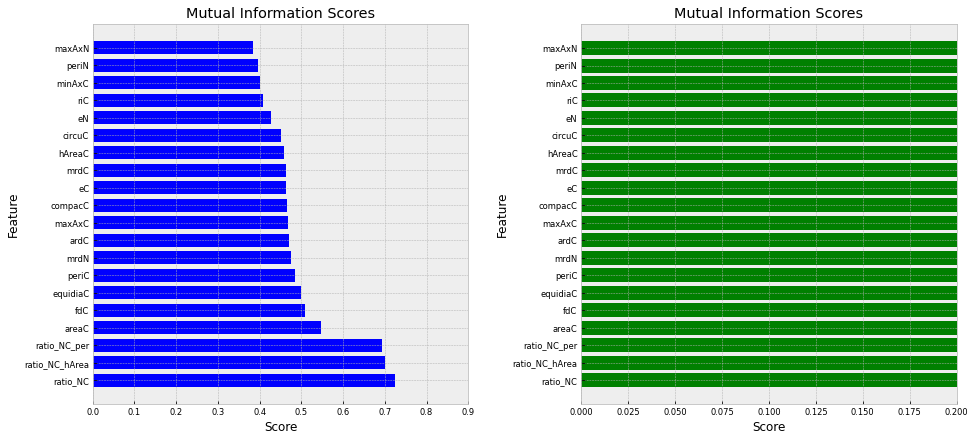

In [83]:
#print(np.array(features_importances))
features_importances = sorted(features_importances.items(), key=lambda item:item[1], reverse=True)
best_features_mutual_info = []
feature_importances_mutual_info = []
for i in list(range(N_FEATURES)):
    best_features_mutual_info.append(features_importances[i][0])
    feature_importances_mutual_info.append(features_importances[i][1]/30)

best_features_MI = np.asarray(best_features_mutual_info)
feature_importances_MI = np.asarray(feature_importances_mutual_info, dtype = np.float32)    
print(best_features_MI, feature_importances_MI)

fn.plot_imp(best_features_MI, feature_importances_MI, 'Mutual Information', 
         best_features_MI, feature_importances_MI, 'Mutual Information')

In [76]:
data_normal.iloc[0], data_X[0,:]

(image_id                   1
 cell_id                14796
 areaN                    420
 eccenN              0.620924
 extentN             0.833333
                       ...   
 ratio_NC            0.017236
 ratio_NC_per        0.115646
 ratio_NC_hArea       0.01673
 nucleus_position    0.099098
 bethesda                   0
 Name: 0, Length: 123, dtype: object,
 array([198, 122, 12937, 0.013939224979091162, 0.41873417906422244,
        0.8163191202573986, 0.030671843484366867, 0.01847497463580107,
        0.09908548890946439, 0.006192514496210194, 0.9616914053451375,
        0.8831889153891492, 0.012771233725976442, 0.9728723694137845,
        0.04134238270885788, 0.847926267281106, 0.21976216432697748,
        0.14911927176673914, 0.05561881222886757, 0.8286707056044709,
        array([0.36382696]), 0.02111664236816928, 0.02515134535640478,
        0.9861798055070433, 0.3851704542036245, 0.3922465976191685,
        0.4879794317877537, 0.4389389735353599, 0.5825196039503318,
      

#### Classificador binário: normal (NILM) vs anormal (ASC-US, LSIL, ASC-H, HSIL, Carcinoma )

In [97]:
## Retorna base de dados (data_X e data_Y) balanceando amostras entre classes, 
##conforme o tipo do classificador
def get_database_X_Y(data_normal, data_ascus, data_lsil, data_asch, data_hsil,  
    data_car, n_normal=(77*5), n_ascus=77, n_lsil=77, n_asch=77, n_hsil=77, n_car=77, classifier = 'binary'):
    
    if classifier == 'binary':
        #data_cl0  = pd.DataFrame(data=data_normal.loc[sample(range(0, data_normal.shape[0]), n_normal)].values, columns = data_normal.columns)
        data =  pd.DataFrame(data=np.vstack([data_normal.loc[sample(range(0, data_normal.shape[0]), n_normal)].values,
                                   data_ascus.loc[sample(range(0, data_ascus.shape[0]), n_ascus)].values,
                                   data_asch.loc[sample(range(0, data_asch.shape[0]), n_asch)].values,
                                   data_lsil.loc[sample(range(0, data_lsil.shape[0]), n_lsil)].values, 
                                   data_hsil.loc[sample(range(0, data_hsil.shape[0]), n_hsil)].values,
                                   data_car.loc[sample(range(0, data_car.shape[0]), n_car)].values]), 
                                   columns = data_car.columns)        
        # Normaliza dados
        data_norm = normalize_dataset(data)
        print(data_norm.values[0,:])
        print(data_norm.values[0,2:])
        # embaralha linhas dos dados:
        data_norm_shuffled = data_norm.sample(frac = 1).reset_index()  
         
        data_x = data_norm_shuffled.values[:,0:-1]
        print(data_norm_shuffled.values[0,:])
        print(data_norm_shuffled.values[0,2:])
        data_y = np.zeros(data_x.shape[0], dtype = np.int32)
        y = np.zeros(data_x.shape[0])
        for i,v in enumerate(data['bethesda'].values):
             data_y[i] = 0 if v==0 else 1
    return (data_x, data_y)
    

In [98]:
data_X, data_Y = get_database_X_Y(data_normal, data_ascus, data_lsil, data_asch, data_hsil,  
    data_car, n_normal=(77*5), n_ascus=77, n_lsil=77, n_asch=77, n_hsil=77, n_car=77, classifier = 'binary')

[173 12567 0.004792674055372502 0.5383500675343313 0.8089420376703601
 0.020905131971021302 0.022963252027966865 0.05049436419247289
 0.01757406093872186 0.9035794472911985 0.9163352679190784
 0.004558513694694503 0.9593333450029319 0.02342049142658263
 0.8079358379062896 0.20996565044685694 0.15061295460607704
 0.04950871336119301 0.848547258886158 array([0.40368647])
 0.024349663696721265 0.022163994550581063 0.9972419931866271
 0.5328482473766196 0.5113222773455547 0.5919091516004471
 0.5178673076510295 0.6355776002200931 0.44433874039053683
 0.5215698625971267 0.6483160464830044 0.5149732433476594
 0.6176722523778249 0.37674042780899525 0.5876482662308244
 0.4023482502069172 0.6174134308198538 0.510155327211514
 0.3582668545648467 0.32939973195335126 0.6976750475995865
 0.6095112942643682 0.4019973361443298 0.6346952416743643
 0.43209484908423074 0.6711263549019386 0.5430786417965666
 0.7778938835761381 0.3823038190714178 0.3702250559258743
 0.6922323609803575 0.48640201767300023 0

In [95]:
sum(data_Y == 0), sum(data_Y == 1), data_X[0, 2:], data_X[0, :]

(385,
 385,
 array([12779, 0.1433956574185766, 0.5330355199850361, 0.9233566980104392,
        0.23093378230787967, 0.19005202261876894, 0.34549186182162755,
        0.016939100730253162, 0.9069216753930082, 0.936050725525006,
        0.1371331828442438, 0.9866082832802516, 0.28004860862104697,
        0.8225434106192915, 0.2183135224580837, 0.15025416490235424,
        0.027503754221920338, 0.5068849285203905, array([0.39057792]),
        0.20213165432748773, 0.24729848872668614, 0.8733884165510291,
        0.5132604782388559, 0.2403447074142069, 0.7843758924163816,
        0.4116982139082373, 0.5778054257886152, 0.2686040090111648,
        0.5764962815384909, 0.5472659385349544, 0.6700478293597706,
        0.48982693952794915, 0.2423820376953692, 0.7118417315252513,
        0.5449635508250271, 0.7048650917134118, 0.38341779192656594,
        0.5377703840596975, 0.32300465816585905, 0.5725423869811546,
        0.76750636644546, 0.30931356110990005, 0.5289019600920521,
        0.233094

In [46]:
# Lista para filtro de FEATURES para o modelo:
features_all = fn.get_list_feature_labels()

features_all_desc = 'All metrics'
features_c = ['areaC', 'periC','maxAxC', 'minAxC','compacC', 'circuC', 'convexC', 'ratio_NC', 
              'ratio_NC_per', 'dist_to_border_c'] 
features_c_desc = 'Cyto metrics,ratios N/C, dist'
features_n = ['areaN', 'periN','maxAxN', 'minAxN','compacN', 'circuN', 'convexN',  'ratio_NC', 
              'ratio_NC_per', 'dist_to_border_c'] 
features_n_desc = 'Nucleos metrics,ratios N/C, dist'

### Cross-validation:  Normal vs Anormal

In [47]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
lin= 0  ## linha inicial para inclusão no dataframe results
classifiers = ['SVM', 'RF', 'XGBoost']
ci = 0

In [137]:
# Se lected features
features_selected = fs_indices_mutual_info  
features_desc= str(N_FEATURES)+" features selected by MI"  
N_SPLITS = 10 

# Executa cross-validation e mostra curvas ROC
cv = StratifiedKFold(n_splits= N_SPLITS)

accs = precs = recs = specs = f1_scores = aucs = np.zeros((N_SPLITS), dtype = np.float64)
tprs = []
mean_fpr = np.linspace(0, 1, 100)
preds_y = np.zeros_like(data_y)

## Ajusta features para treino e teste
X = data_x[:, 2:]
X = data_x[:,fs_indices_mutual_info]

model = getModel(classifier = classifiers[ci], class_type = 'binary')
for i, (train, test) in enumerate(cv.split(X, data_y)):
    # Ajusta modelo:
    model.fit(X[train], data_y[train])    
    
    # Predição:
    pred_y = model.predict(X[test])
    prob_y = model.predict_proba(X[test])
    
    #Registra predições:
    preds_y[test] = pred_y
    
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(data_y[test], pred_y, metric_type='acc')
    precs[i] = calc_metric(data_y[test], pred_y, metric_type='prec')                
    recs[i] = calc_metric(data_y[test], pred_y, metric_type='rec')                
    specs[i] = calc_metric(data_y[test], pred_y, metric_type='spec')                
    f1_scores[i] = calc_metric(data_y[test], pred_y, metric_type='f1_score')                
       
    # Calcula curva_roc e AUC:
    prob = prob_y[:, 1]
    fpr, tpr, thresholds = roc_curve(data_y[test], prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs[i]= auc(mean_fpr, interp_tpr)
                     
## Registra resultados (dataframe):
metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
           'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}                                      
fill_line_metrics_CV(classifiers[ci], features_desc, lin, metrics, results, class_type='binary')

# Calcula e registra curva ROC (média CV)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
roc_curve_list.append((mean_fpr, mean_tpr))
label = r"Mean ROC (AUC %s= %0.4f $\pm$ %0.4f)" % ((classifiers[ci]+"-binary "), mean_auc, std_auc)
labels_list.append(label)

# Acumula Matrizes de confusão:
conf_matrix_list.append(make_confusionMatrixDisplay(
      data_y, preds_y, labels = [0,1], title=features_desc + "- "+classifiers[ci]))

lin+= 1
ci+= 1                     

# Exibe curva ROC para classificador Binário (cross validation)
def plot_roc_curve_CV(roc_curve_list, labels_list, title = "ROC Curve - Normal vs Anormal"):
    fig, ax = plt.subplots(figsize=(9,5))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    for i,color in zip(range(len(roc_curve_list)), colors):
        ax.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            label=labels_list[i],
            lw=2,
            alpha=0.8,
        )
 
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title= title
    )
    ax.legend(loc="lower right")
    plt.show()



In [138]:
len(labels_list), len(roc_curve_list), len(conf_matrix_list)

(3, 3, 3)

### Resultados:

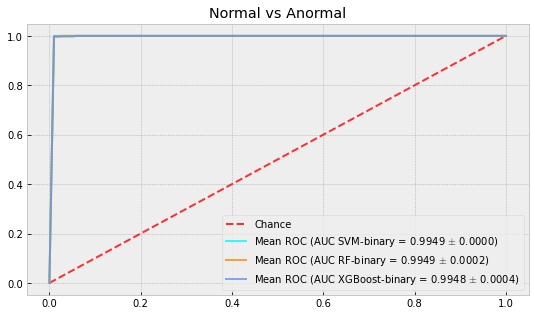

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,binary,SVM,20 features selected by MI,0.9949,0.9949,0.9949,0.0051,0.9949,0.9949
1,binary,RF,20 features selected by MI,0.9949,0.9949,0.9949,0.0051,0.9949,0.9949
2,binary,XGBoost,20 features selected by MI,0.9948,0.9948,0.9948,0.0052,0.9948,0.9948


In [139]:
plot_roc_curve_CV(roc_curve_list, labels_list, title = "Normal vs Anormal")
results


#### Matrizes de confução

<Figure size 432x288 with 0 Axes>

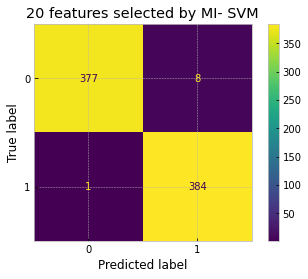

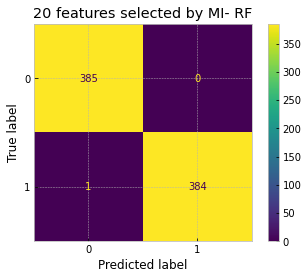

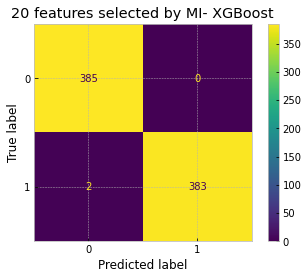

<Figure size 432x288 with 0 Axes>

In [140]:
#%matplotlib inline    

plt.figure(figsize=(6, 4))   #tupla para tamanho da figura (largura, altura)

for i in range(len(conf_matrix_list)):
    conf_matrix_list[i][0].plot()
    plt.title(conf_matrix_list[i][1])

plt.show()
plt.tight_layout()    #inclui espaçamento entre os gráficos

In [ ]:
# Exibe gráficos boxplot - dist nucleo borda:
fig = plt.figure(figsize =(15, 10))
ax = fig.add_subplot(111)

dist = []
num_samples = 77
for i in Bethesda_idx_classes.keys():
      dist.append(data_x[(0 + i*num_samples):((i+1)*num_samples), 14])

ax.boxplot(dist_to_C_border_cells, labels = ['Normal', 'ASC-US', 'ASC-H', 'LSIL','HSIL', 'Invasive Carcinoma'], patch_artist = True,
                notch ='True') 
ax.set_title("Proximidade do Núcleo da borda (citoplasma)")